In [6]:
import copy
import time
import os
import random
import json

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from Datasets.Morph2.DataParser import DataParser
from Datasets.Morph2.Morph2ClassifierDataset import Morph2ClassifierDataset
from transformer_main import get_age_transformer

In [7]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True

cuda:0


## Load Data

In [9]:
data_parser = DataParser('./Datasets/Morph2/aligned_data/aligned_dataset_with_metadata_uint8.hdf5')
data_parser.initialize_data()
x_train, y_train, x_test, y_test = data_parser.x_train,	data_parser.y_train, data_parser.x_test, data_parser.y_test,

In [10]:
Y = np.concatenate((y_train, y_test), axis=0)
len(Y)

54891

In [5]:
len(y_test)

10606

In [6]:
min_age = 15
max_age = 80
age_interval = 10
num_copies = 6

In [7]:
test_ds = Morph2ClassifierDataset(
    x_test,
    y_test,
    min_age,
    age_interval,
    transform=transforms.Compose([
        transforms.RandomResizedCrop(224, (0.9, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1
        )], p=0.5),
        transforms.RandomApply([transforms.RandomAffine(
            degrees=10,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            shear=5,
            resample=Image.BICUBIC
        )], p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5)
    ]),
    copies=num_copies
)

In [8]:
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0, pin_memory=True, shuffle=False, drop_last=True)

## Load Model

In [10]:
num_classes = int((max_age - min_age) / age_interval + 1)
mid_feature_size = 1024

In [11]:
model = get_age_transformer(device, num_classes, age_interval, min_age, max_age, mid_feature_size)
pretrained_model_path = 'weights/Morph2/transformer/encoder/layers_8_heads_8_1e6_batch_12_copies_6_mid_feature_size_1024_augs_at_val_imgsize_224_myloss_dropout_03_2fc_context_true_iter_warmup_10000_amp_batchnorm_after_encoder_iter_15e5'
pretrained_model_file = os.path.join(pretrained_model_path, "weights.pt")
model.load_state_dict(torch.load(pretrained_model_file), strict=False)
model.to(device)
model.eval()
print('model loaded')

model loaded


## Forward

In [12]:
age_preds = []
age_labels = []
class_preds = []
class_labels = []
genders = []
races = []
for idx, batch in tqdm(enumerate(test_dl)):
    inputs = batch['image'].to(device)
    class_label = batch['classification_label'].to(device).float()
    age_label = batch['age'].to(device).float()
    metadata = json.loads(test_ds.metadata[idx])
    race = metadata['race']
    gender = metadata['gender']
    
    with torch.no_grad():
        classification_logits, age_pred = model(inputs)
        _, class_pred = torch.max(classification_logits, 1)
    
    age_preds.append(age_pred) 
    age_labels.append(age_label)
    class_preds.append(class_pred)
    class_labels.append(class_label)
    genders.append(gender)
    races.append(race)

0it [00:00, ?it/s]D:\code\thesis_pytorch\Models\transformer.py:127: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = nn.Softmax()(classification_logits)
10606it [12:31, 14.11it/s]


## Create df

In [9]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

In [15]:
data = {'age_preds': age_preds, 'age_labels': age_labels, 'class_labels': class_labels, 'class_preds': class_preds, 'genders': genders, 'races': races}
df = pd.DataFrame(data=data)

race_dict = {'W':'White', 'B':'Black', 'H':'Hispanic', 'O':'Other', 'A':'Asian'}
gender_dict = {'M':'Male', 'F':'Female'}

df['age_preds'] = df['age_preds'].apply(lambda x: x.cpu().detach().numpy()[0])
df['age_labels'] = df['age_labels'].apply(lambda x: x.cpu().detach().numpy()[0])
df['class_preds'] = df['class_preds'].apply(lambda x: x.cpu().detach().numpy()[0])
df['class_labels'] = df['class_labels'].apply(lambda x: x.cpu().detach().numpy()[0])

df['genders'] = df['genders'].apply(lambda x: gender_dict[x])
df['races'] = df['races'].apply(lambda x: race_dict[x])

df = df[df['races'] != 'Other']


df.head(10)

,age_preds,age_labels,class_labels,class_preds,genders,races
0,60.199032,67.0,5.0,4,Male,White
1,57.763767,67.0,5.0,4,Male,White
2,54.895626,59.0,4.0,3,Male,Black
3,57.001770,60.0,4.0,4,Male,Black
4,57.513706,60.0,4.0,4,Male,Black
5,55.034241,60.0,4.0,3,Male,Black
6,57.793091,60.0,4.0,4,Male,Black
7,56.695229,63.0,4.0,4,Male,Black
8,51.974430,58.0,4.0,3,Male,Black
9,52.591015,58.0,4.0,3,Male,Black


In [16]:
df['abs_age_diff'] = np.abs(df['age_preds'] - df['age_labels'])

In [18]:
# df.to_csv('results.csv')

# Analyze

### if you have the results csv you can start from here

In [11]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

In [12]:
df = pd.read_csv('results.csv')

In [13]:
df['age_diff'] = df['age_preds'] - df['age_labels']

In [14]:
print(f"CS(5):{np.sum(df['abs_age_diff'] <= 5) / len(df['abs_age_diff'])}")

CS(5):0.8734296779068669


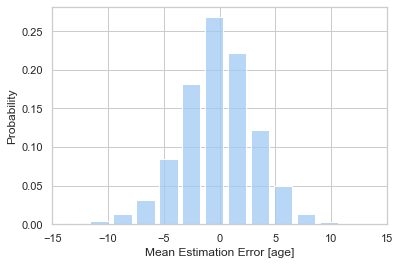

In [15]:
sns_plot = sns.histplot(
    data=df, 
    x="age_diff",
    bins=20,
    stat="probability", 
    multiple="dodge",
    common_norm=False,
    shrink=.8
)

sns_plot.set(xlabel='Mean Estimation Error [age]', ylabel='Probability')
sns_plot.set(ylim=(0, None))
sns_plot.set(xlim=(-15, 15))
sns_plot.get_figure().savefig('./plots/estimation_error_not_abs.pdf',dpi=300)

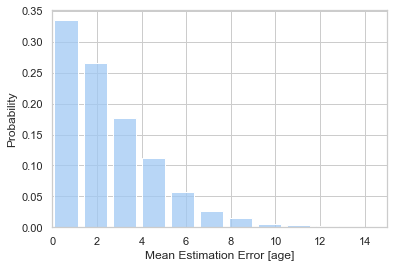

In [16]:
sns_plot = sns.histplot(
    data=df, 
    x="abs_age_diff",
    bins=20,
    stat="probability", 
    multiple="dodge",
    common_norm=False,
    shrink=.8
)

sns_plot.set(xlabel='Mean Estimation Error [age]', ylabel='Probability')
sns_plot.set(ylim=(0, None))
sns_plot.set(xlim=(0, 15))
sns_plot.get_figure().savefig('./plots/estimation_error.pdf',dpi=300)

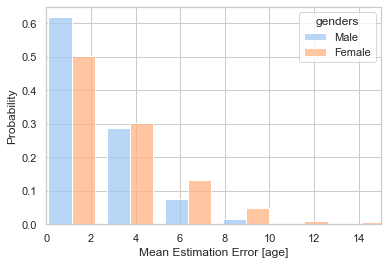

In [17]:
sns_plot = sns.histplot(
    data=df, 
    x="abs_age_diff",
    hue="genders",
    bins=10,
    stat="probability", 
    multiple="dodge",
    common_norm=False,
    shrink=.8
)

sns_plot.set(xlabel='Mean Estimation Error [age]', ylabel='Probability')
sns_plot.set(ylim=(0, None))
sns_plot.set(xlim=(0, 15))
sns_plot.get_figure().savefig('./plots/error_per_gender.pdf',dpi=300)

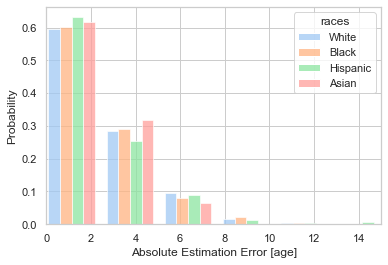

In [18]:
sns_plot = sns.histplot(
    data=df, 
    x="abs_age_diff",
    hue="races",
    bins=10,
    stat="probability", 
    multiple="dodge",
    common_norm=False,
    shrink=0.8
)

sns_plot.set(xlabel='Absolute Estimation Error [age]', ylabel='Probability')
sns_plot.set(ylim=(0, None))
sns_plot.set(xlim=(0, 15))
sns_plot.get_figure().savefig('./plots/error_per_race.pdf',dpi=300)

In [19]:
meta_df = pd.read_csv('./Datasets/Morph2/morph_2008_nonCommercial.csv')

In [23]:
meta_df.head()

,id_num,picture_num,dob,doa,race,gender,facial_hair,age,age_diff,glasses,photo
0,9055,0,06/13/1949,09/08/2003,W,M,NaN,54,NaN,NaN,Album2/009055_0M54.JPG
1,9055,1,06/13/1949,10/23/2003,W,M,NaN,54,45.0,NaN,Album2/009055_1M54.JPG
2,19066,0,12/14/1935,12/08/2003,B,M,NaN,67,NaN,NaN,Album2/019066_0M67.JPG
3,19066,1,12/14/1935,01/23/2004,B,M,NaN,68,46.0,NaN,Album2/019066_1M68.JPG
4,19066,2,12/14/1935,03/21/2005,B,M,NaN,69,423.0,NaN,Album2/019066_2M69.JPG


In [24]:
meta_df['age_labels_5'] = meta_df['age'].apply(lambda x: 5 * round(x/5))
meta_df.head()

,id_num,picture_num,dob,doa,race,gender,facial_hair,age,age_diff,glasses,photo,age_labels_5
0,9055,0,06/13/1949,09/08/2003,W,M,NaN,54,NaN,NaN,Album2/009055_0M54.JPG,55
1,9055,1,06/13/1949,10/23/2003,W,M,NaN,54,45.0,NaN,Album2/009055_1M54.JPG,55
2,19066,0,12/14/1935,12/08/2003,B,M,NaN,67,NaN,NaN,Album2/019066_0M67.JPG,65
3,19066,1,12/14/1935,01/23/2004,B,M,NaN,68,46.0,NaN,Album2/019066_1M68.JPG,70
4,19066,2,12/14/1935,03/21/2005,B,M,NaN,69,423.0,NaN,Album2/019066_2M69.JPG,70


In [29]:
meta_df['age_labels_5'].value_counts()

20    9703
35    8638
25    8243
40    7552
30    6243
45    5884
50    3421
15    3330
55    1569
60     399
65     124
70      22
75       6
Name: age_labels_5, dtype: int64

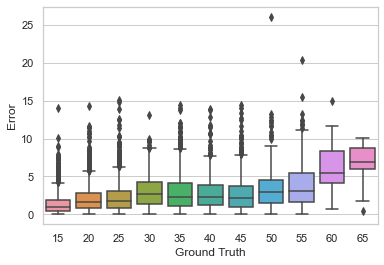

In [30]:
df['age_labels_5'] = df['age_labels'].apply(lambda x: 5 * round(x/5))
sns_plot = sns.boxplot(
    data=df, 
    x="age_labels_5",
    y="abs_age_diff",
)

sns_plot.set(xlabel='Ground Truth', ylabel='Error')
sns_plot.get_figure().savefig('./plots/error_per_age_bin_5.pdf', dpi=300)

In [ ]:
age = 70
print('mean ' + str(df[df['age_labels_5'] == age]['abs_age_diff'].mean()))
print('std ' + str(df[df['age_labels_5'] == age]['abs_age_diff'].std()))

In [40]:
num_examples = 25
indices = np.argsort(df['abs_age_diff'])
best_k = indices[:num_examples].tolist()
worst_k = indices[-num_examples:].tolist()

<ipython-input-22-c544af014ef5>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, 1, figsize=[5, 5])


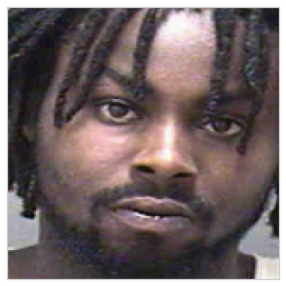

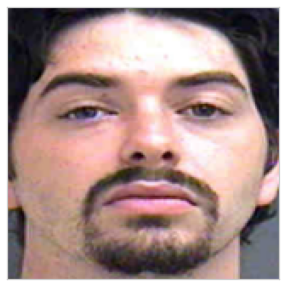

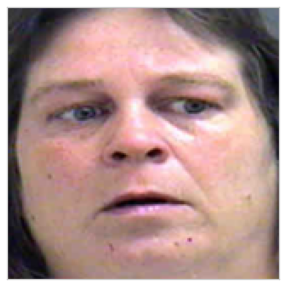

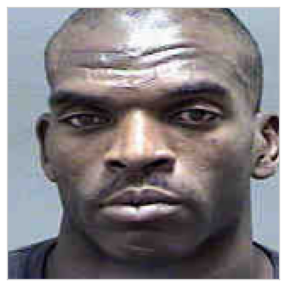

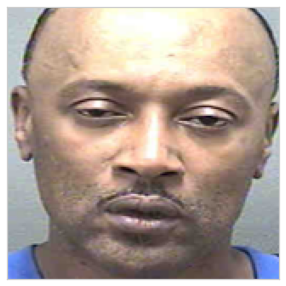

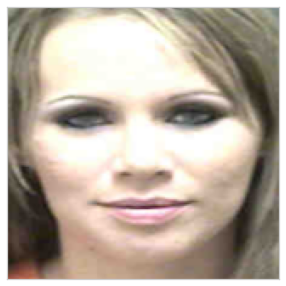

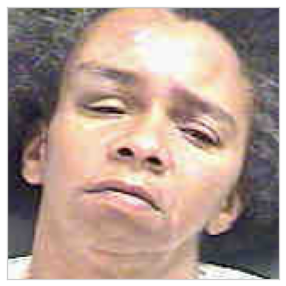

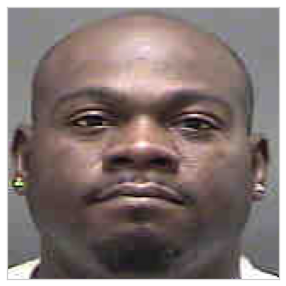

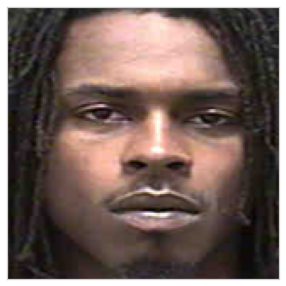

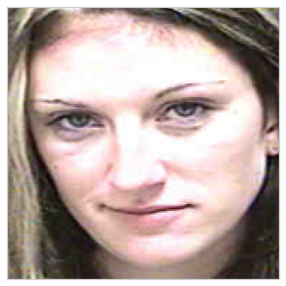

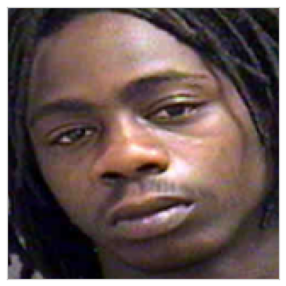

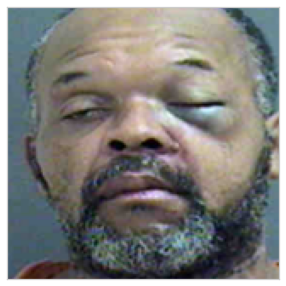

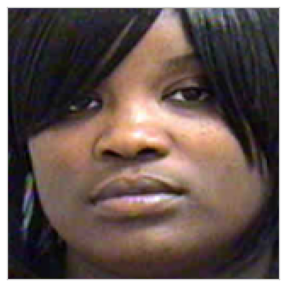

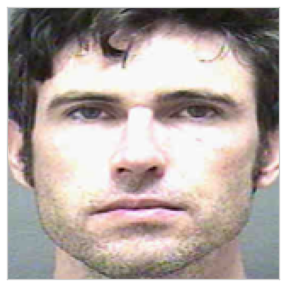

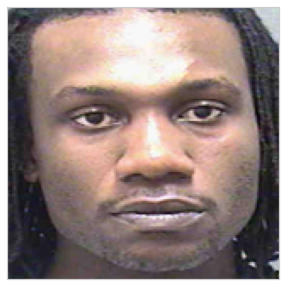

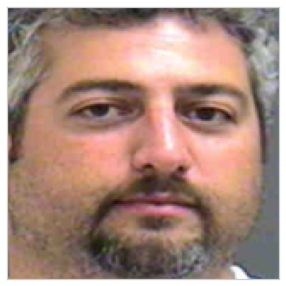

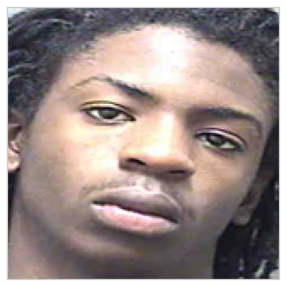

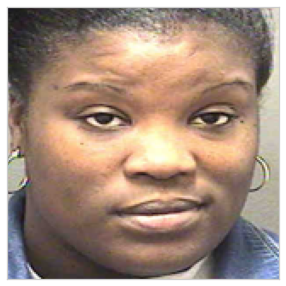

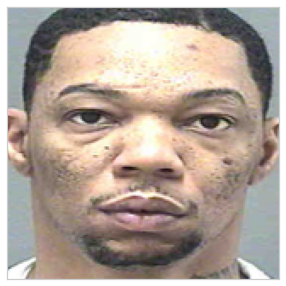

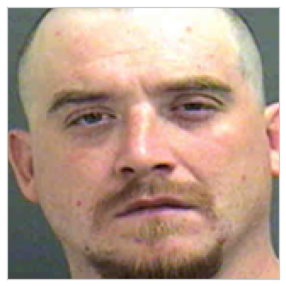

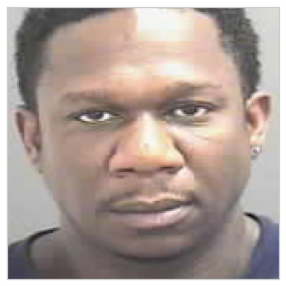

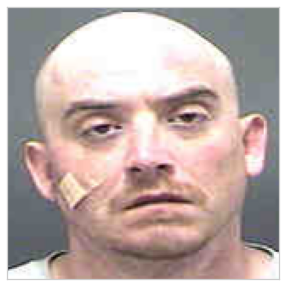

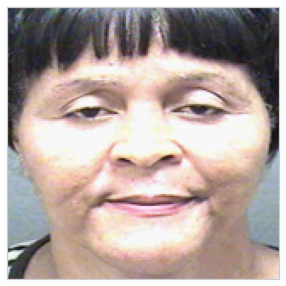

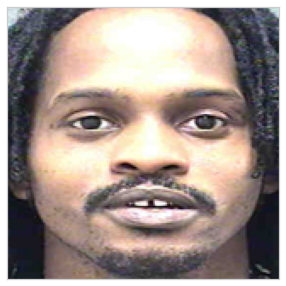

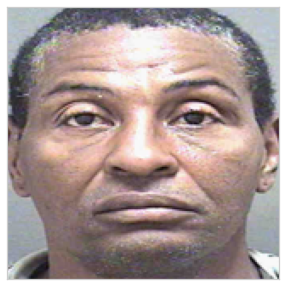

In [22]:
# f, axs = plt.subplots(1, num_examples, figsize=[15, 5])

# row_axs = axs[0]
# for i, ax in enumerate(row_axs):
#     idx = best_k[i]
#     im = test_ds.images[idx]
#     ax.imshow(im)
#     ax.grid(False)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     ax.set_title(f"est: {df['age_preds'].iloc[idx]:.2f} - gt: {df['age_labels'].iloc[idx]}")
    
# row_axs = axs
for i in range(num_examples):
    f, ax = plt.subplots(1, 1, figsize=[5, 5])
    idx = worst_k[i]
    im = test_ds.images[idx]
    ax.imshow(im)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#     name = f"est {df['age_preds'].iloc[idx]:.2f} gt {df['age_labels'].iloc[idx]}"
    name = f"{df['age_labels'].iloc[idx] -df['age_preds'].iloc[idx]:.2f}"

    f.savefig(f'./plots/bad_estimation_examples/diffs/{name}.pdf', dpi=300)

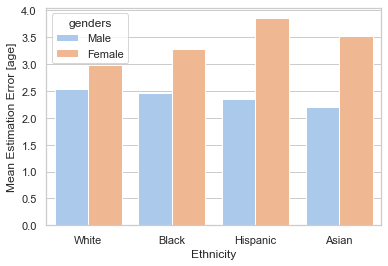

In [59]:
# import seaborn as sns
sns_plot = sns.barplot(
    data=df, 
    x="races",
    y="abs_age_diff",
    hue="genders", 
    ci=None
)

sns_plot.set(ylabel='Mean Estimation Error [age]', xlabel='Ethnicity')
sns_plot.get_figure().savefig('./plots/mae_per_gender_per_race.pdf',dpi=300)